<a href="https://colab.research.google.com/github/MadimuriVineela/ecommerce/blob/main/forgery_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d sophatvathana/casia-dataset

Dataset URL: https://www.kaggle.com/datasets/sophatvathana/casia-dataset
License(s): unknown
100% 5.21G/5.22G [00:54<00:00, 121MB/s]
100% 5.22G/5.22G [00:54<00:00, 103MB/s]


In [ ]:
!unzip casia-dataset.zip -d casia-dataset

Streaming output truncated to the last 5000 lines.
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00008_nat10122_11773.jpg  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: casia-dataset/casia/CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  i

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.convert('L')
    return ela_image

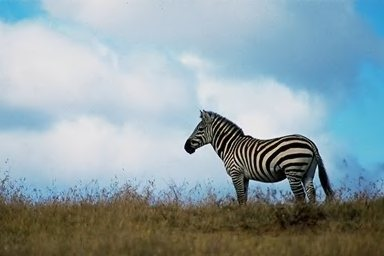

In [ ]:
real_image_path = '/content/casia-dataset/casia/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

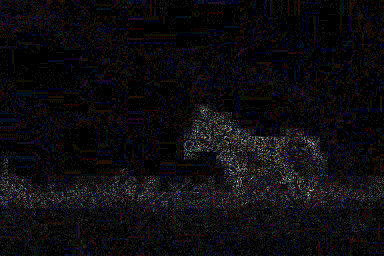

In [ ]:
convert_to_ela_image(real_image_path, 90)

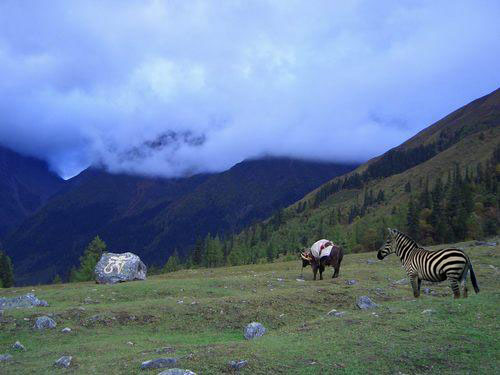

In [ ]:
fake_image_path = '//content/casia-dataset/casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

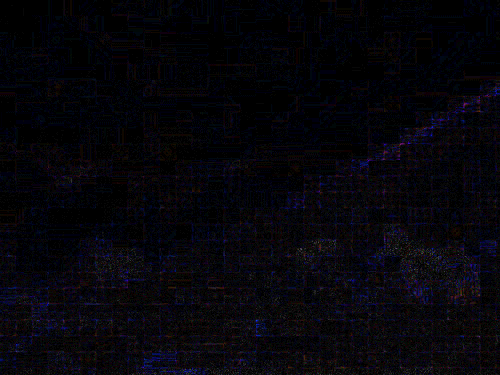

In [ ]:
convert_to_ela_image(fake_image_path, 90)

In [ ]:
image_size = (128, 128)

In [ ]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [ ]:
import random
path = '/content/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
path = '/content/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [ ]:
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
batch_size = 32

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Initialize the learning rate and optimizer
init_lr = 1e-4
optimizer = Adam(learning_rate=init_lr)

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    decay_rate = init_lr / epochs
    return lr * (1 / (1 + decay_rate * epoch))

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=5, verbose=1)

# Fit the model with early stopping
hist = model.fit(X_train,
                 Y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_val, Y_val),
                 callbacks=[early_stopping])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.6016 - loss: 0.6144 - val_accuracy: 0.8667 - val_loss: 0.3762
Epoch 2/30
  5/105 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8913 - loss: 0.3520

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8867 - loss: 0.3317 - val_accuracy: 0.8667 - val_loss: 0.3757
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8862 - loss: 0.3259 - val_accuracy: 0.8667 - val_loss: 0.4022
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8955 - loss: 0.3108 - val_accuracy: 0.9052 - val_loss: 0.2934
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9090 - loss: 0.2759 - val_accuracy: 0.8932 - val_loss: 0.3397
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8991 - loss: 0.2758 - val_accuracy: 0.9076 - val_loss: 0.2505
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9258 - loss: 0.2076 - val_accuracy: 0.9148 - val_loss: 0.2466
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9299 - loss: 0.2078 - val_accuracy: 0.9208 - val_loss: 0.2305
Epoch 9/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9321 - loss: 0.1929 - val_accuracy: 0.911

In [ ]:
model.save('forgery_detection.keras')

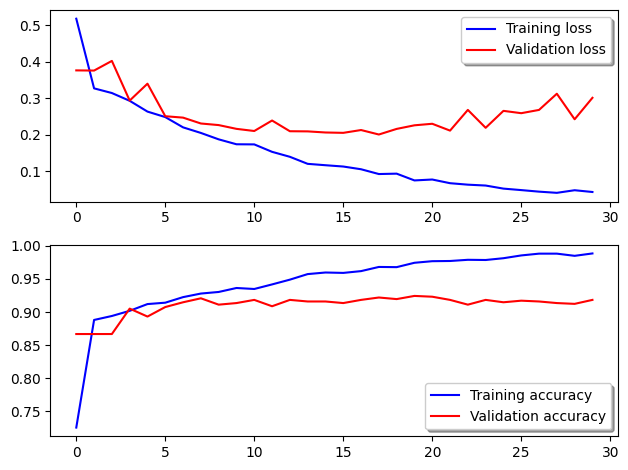

In [ ]:
import matplotlib.pyplot as plt

# Assuming hist is the training history object
fig, ax = plt.subplots(2, 1)

# Plot training and validation loss
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)

# Plot training and validation accuracy
ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


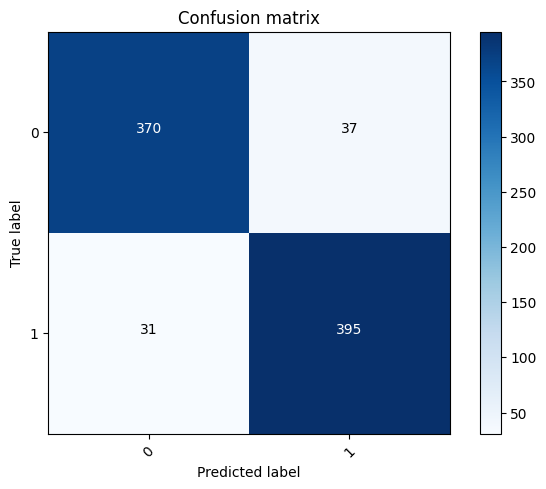

In [ ]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
fake_image = os.listdir('/content/casia-dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/casia-dataset/casia/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2021, Acc: 97.91666666666666


In [ ]:
real_image = os.listdir('/content/casia-dataset/casia/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/casia-dataset/casia/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [ ]:
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Total: 7354, Correct: 6924, Acc: 94.15284199075333


In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 9418, Correct: 8945, Acc: 94.97770227224464


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


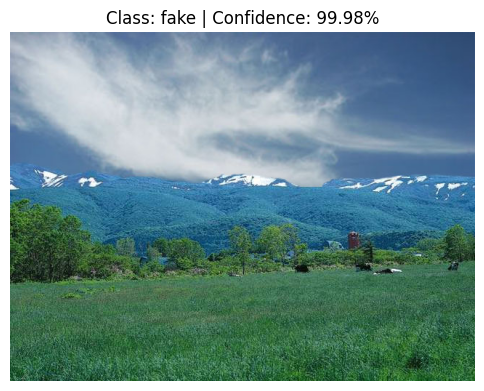

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class_names = ['fake', 'real']
image_path = '/content/casia-dataset/CASIA2/Tp/Tp_D_CRN_M_N_nat10139_nat10124_11946.jpg'

# Prepare and reshape the image
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)

# Predict the class
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis=1)[0]
confidence = np.amax(y_pred) * 100

# Load and display the original image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.axis('off')
plt.title(f'Class: {class_names[y_pred_class]} | Confidence: {confidence:.2f}%')
plt.show()
